<a href="https://colab.research.google.com/github/DarshanDinni/learn_pytorch/blob/main/02_Pytorch_classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Importing libraries
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

#**Build dataset**

We will be using make_circles() from sklearn which generates data points denoting large circle containing a smaller circle in 2d.

We will be building deep learning model to classify the 2 circles.

This is a binary classification problem as it has only 2 labels which is either 0 or 1.

In [42]:
# Build the dataset
# n_samples to represent how many data points we want
n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.05)

# X represents data point values for the inside and outside cirle
print(f'First 5 X values are: \n {X[:5]}')

# y represents the integer labels (0 or 1) for class membership of each sample
print(f'First 5 y values are: \n {y[:5]}')

First 5 X values are: 
 [[ 0.94966537  0.3221215 ]
 [ 0.13937049  0.79298118]
 [ 0.8136799   0.39159256]
 [-0.51011173  0.81590399]
 [-0.71507285  0.40962195]]
First 5 y values are: 
 [0 1 1 0 1]


In [43]:
X.shape, y.shape

((1000, 2), (1000,))

#**Visualize the data**

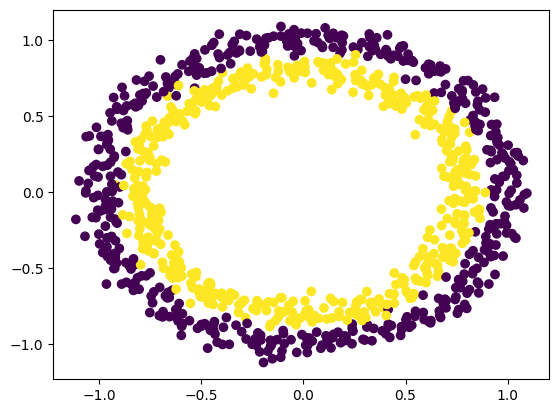

In [44]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [45]:
# As for building deep learning model we need tensors, so we are converting X and y to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.9497,  0.3221],
         [ 0.1394,  0.7930],
         [ 0.8137,  0.3916],
         [-0.5101,  0.8159],
         [-0.7151,  0.4096]]),
 tensor([0., 1., 1., 0., 1.]))

#**Spliting the data**

In [46]:
# Spliting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: torch.Size([800, 2])
Shape of X_test: torch.Size([200, 2])
Shape of y_train: torch.Size([800])
Shape of y_test: torch.Size([200])


#**Build a model**

Build a model to classify the 2 circles.

In [48]:
# Setting the agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [49]:
# Construct the model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # We are creating 3 layer neural network which has input layer of 2 features, hidden layer of 5 features (this number can change but to keep it simple we have choosen 5),
    # output layer of 1 (ie, either 0 or 1)
    self.linear_layer_1 = nn.Linear(in_features=2, out_features=5)
    self.linear_layer_2 = nn.Linear(in_features=5, out_features=1)

  # We have to overwrite this function as we are inherting nn.Module
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # tensor x is passed to layer 1 and layer 1 outputs 5 features and that 5 features are passed to layer 2 and that outputs the class of circle (either 1 or 0)
    return self.linear_layer_2(self.linear_layer_1(x))

In [50]:
# Instantiate the model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (linear_layer_1): Linear(in_features=2, out_features=5, bias=True)
  (linear_layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [51]:
# Simpler way of creating the same model above
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [52]:
# Predicting the values on untrained model to check its performance
with torch.inference_mode():
  y_pred_untrained_model = model_0(X_test.to(device))

print(f'Actual values that our model should be predicting: {y_test[:5]}\n')
print(f'Model predicting on the test data: {y_pred_untrained_model[:5]}')

Actual values that our model should be predicting: tensor([0., 1., 0., 0., 1.])

Model predicting on the test data: tensor([[ 0.2293],
        [-0.2727],
        [-0.4524],
        [ 0.2543],
        [-0.3421]], device='cuda:0')


In [53]:
# Creating loss function
# As our problem we are trying to solve is classification so we are using Binary cross entropy loss or BSEWithLogitsLoss which is commonly used for classification problem
# We are using BCEWithLogitsLoss because it has sigmoid function build in
loss_function = nn.BCEWithLogitsLoss()

# Setting optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

#**Train the model**

In [54]:
# Setting how many time we want to iterate the loop to train the model so it learns, this value can be changed based on how model learns.
epochs = 1000

epoch_values = []
train_loss = []
test_loss = []

# Setting all the training and testing data points to the same device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):

  # Step 1: We write this to tells the model that we are training the model. This helps inform layers which are designed to behave differently during training and evaluation phase
  model_0.train()

  # Step 2: Put the training data points through the forward pass function to predict the label values so that we can train the model
  # Our loss function which is BCEWithLogitsLoss need raw logits and label values as input, and when we perform training model returns predicted values with 1 extra dimensions
  # To remove that we use squeeze() so that the predicted label are in same format as original labels
  y_pred_train = model_0(X_train).squeeze()

  # Step 3: We use the above defined loss function
  training_loss = loss_function(y_pred_train, y_train)

  # Step 4: Making the optimizer gradients to zero
  optimizer.zero_grad()

  # Step 5:  All this does is compute gradient of loss w.r.t all the parameters in loss that have requires_grad = True and store them in parameter
  training_loss.backward()

  # Step 6:  Performs a parameter update based on the current gradient (stored in . grad attribute of a parameter) and the update rule
  optimizer.step()

  # Step 7: We write this to tells the model that we are testing the model. This helps inform layers which are designed to behave differently during training and evaluation phase
  model_0.eval()

  # We are using inference_mode so that code can better perform by disabling view tracking and version counter bumps
  with torch.inference_mode():
    y_pred_test = model_0(X_test).squeeze()
    testing_loss = loss_function(y_pred_test, y_test)

  if epoch % 10 == 0:
    epoch_values.append(epoch)
    train_loss.append(training_loss)
    test_loss.append(testing_loss)
    print(f"Epoch {epoch}: Training loss: {training_loss: .5f}, Testing loss: {testing_loss: .5f}")

Epoch 0: Training loss:  0.70456, Testing loss:  0.69043
Epoch 10: Training loss:  0.70174, Testing loss:  0.69007
Epoch 20: Training loss:  0.69969, Testing loss:  0.69004
Epoch 30: Training loss:  0.69817, Testing loss:  0.69020
Epoch 40: Training loss:  0.69702, Testing loss:  0.69047
Epoch 50: Training loss:  0.69614, Testing loss:  0.69080
Epoch 60: Training loss:  0.69546, Testing loss:  0.69117
Epoch 70: Training loss:  0.69492, Testing loss:  0.69155
Epoch 80: Training loss:  0.69451, Testing loss:  0.69192
Epoch 90: Training loss:  0.69417, Testing loss:  0.69229
Epoch 100: Training loss:  0.69391, Testing loss:  0.69264
Epoch 110: Training loss:  0.69370, Testing loss:  0.69297
Epoch 120: Training loss:  0.69353, Testing loss:  0.69328
Epoch 130: Training loss:  0.69340, Testing loss:  0.69356
Epoch 140: Training loss:  0.69329, Testing loss:  0.69382
Epoch 150: Training loss:  0.69320, Testing loss:  0.69406
Epoch 160: Training loss:  0.69313, Testing loss:  0.69428
Epoch 17

In [55]:
# As we can see that our model is not learning over 100 epoch then there must be some issue
# To understand this lets visualize the prediction

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

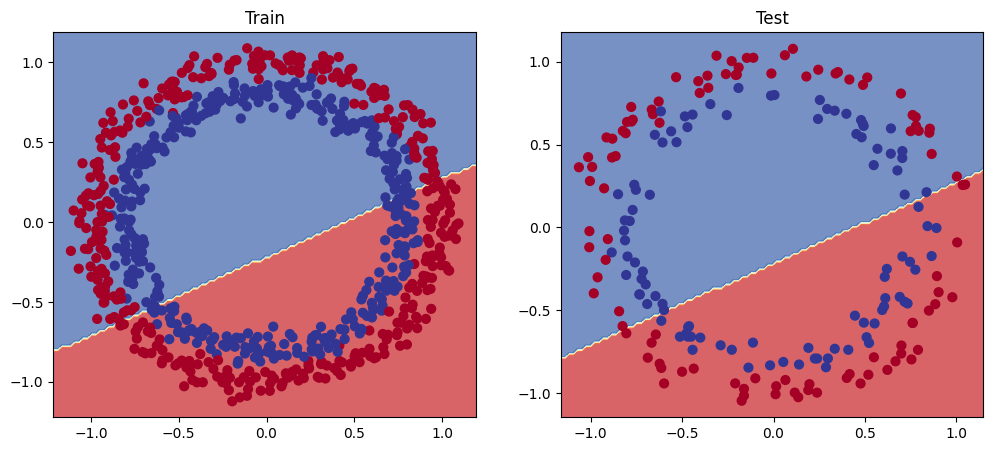

In [56]:
# Lets plot the graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

plt.show()

From the above visualization its clear that out model is seperating the data in linear fasion but our data is non linear.

So to improve this we can do following things:
- Add more layers in the neural network
- Use non linear activation functions
- Change the number of hidden layers
- Try changing the loss function and optimizer etc

#**Building model to solve the non linearity in the data**

In [57]:
# Construct the model for the non linear data
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer_1 = nn.Linear(in_features=2, out_features=10)
    self.linear_layer_2 = nn.Linear(in_features=10, out_features=10)
    self.linear_layer_3 = nn.Linear(in_features=10, out_features=1)

    # Introducing nonlinearity.
    # This nonlinearity allows neural networks to develop complex representations and functions based on the inputs that would not be possible with a simple linear regression model
    self.relu = nn.ReLU()

  # We have to overwrite this function as we are inherting nn.Module
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # The first layer and the second layer is passed through the relu activation so that our model can learn the non linear data.
    return self.linear_layer_3(self.relu(self.linear_layer_2(self.relu(self.linear_layer_1(x)))))

In [58]:
# Instantiate the new model and make it device capable
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (linear_layer_1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer_2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [59]:
# Setting up the loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [60]:
epochs = 1000
epoch_value = []
training_loss = []
testing_loss = []

for epoch in range(epochs):

  # Step 1:Setting the model for training mode
  model_1.train()

  # Step 2: Model predicting on the training sample
  # Using squeeze to remove the extra dimension so that it becomes compatible for the loss function with y_train in next step
  y_pred_train = model_1(X_train).squeeze()

  # Step 3: Calculating the training loss
  train_loss = loss_function(y_pred_train, y_train)

  # Step 4: Reseting the gradients of optimizer for better learning
  optimizer.zero_grad()

  # Step 5: Performing the gradient descent to update the value of network to better fit the data
  train_loss.backward()

  # Step 6: Moving into the gradient direction to reduce the loss
  optimizer.step()

  # Step 7:Setting the model for testing mode
  model_1.eval()
  # Inference mode to avoid un-necessary thing during testing phase
  with torch.inference_mode():
    y_pred_test = model_1(X_test).squeeze()
    test_loss = loss_function(y_pred_test, y_test)

  if epoch % 10 == 0:
    epoch_value.append(epoch)
    training_loss.append(train_loss)
    testing_loss.append(test_loss)
    print(f"Epoch {epoch}: Training loss: {train_loss}, Testing loss: {test_loss}")

Epoch 0: Training loss: 0.7113792300224304, Testing loss: 0.7190641760826111
Epoch 10: Training loss: 0.7009689211845398, Testing loss: 0.7069786190986633
Epoch 20: Training loss: 0.6959613561630249, Testing loss: 0.7006769180297852
Epoch 30: Training loss: 0.6934711933135986, Testing loss: 0.6972145438194275
Epoch 40: Training loss: 0.692184567451477, Testing loss: 0.6952215433120728
Epoch 50: Training loss: 0.6914817690849304, Testing loss: 0.6940101385116577
Epoch 60: Training loss: 0.691059410572052, Testing loss: 0.6932270526885986
Epoch 70: Training loss: 0.6907752752304077, Testing loss: 0.692689061164856
Epoch 80: Training loss: 0.6905580759048462, Testing loss: 0.692291259765625
Epoch 90: Training loss: 0.6903694272041321, Testing loss: 0.6919760704040527
Epoch 100: Training loss: 0.6901916861534119, Testing loss: 0.6917101740837097
Epoch 110: Training loss: 0.690014660358429, Testing loss: 0.6914761066436768
Epoch 120: Training loss: 0.6898339986801147, Testing loss: 0.691253

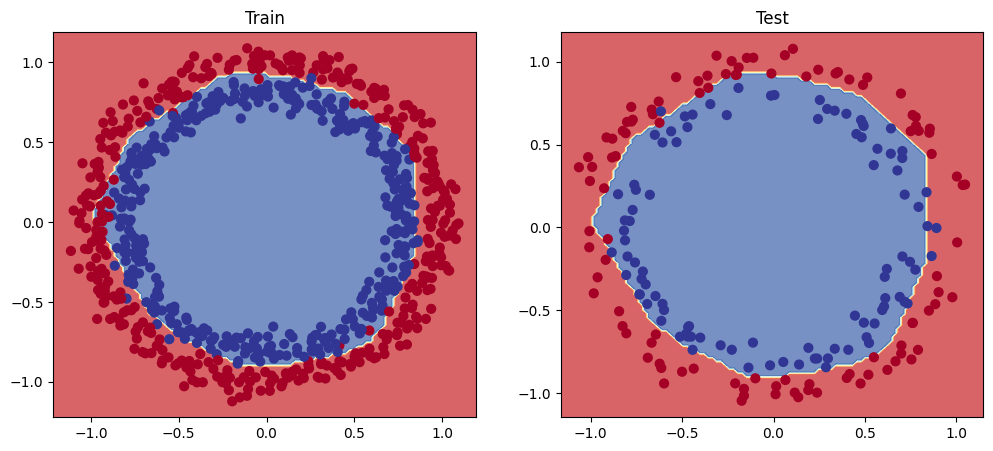

In [61]:
# Lets plot the graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

plt.show()

As we can see that adding non linearity makes the model performance better.

From the above graph its clear that now our model 1 can predict better than model 0